In [181]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

In [182]:
image = cv2.imread(r'water_body.jpg')
mask = cv2.imread(r'water_body_Masked.jpg' , 0)
image_bw = cv2.imread(r'water_body.jpg' , 0)

In [183]:
mask = mask/255

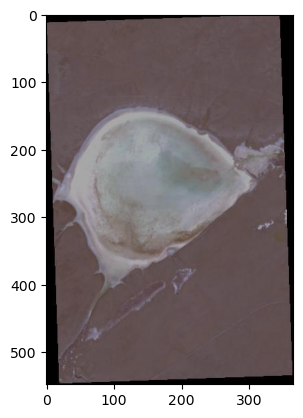

In [184]:
plt.imshow(image)

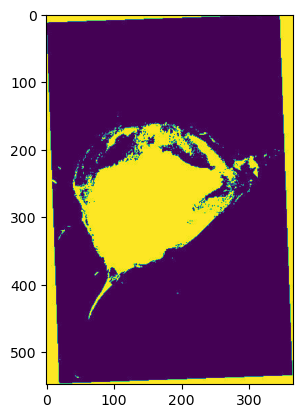

In [185]:
plt.imshow(mask)

Image Preprocessing

In [186]:
def preprocess(image):

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

    enhanced_img = clahe.apply(image)

    return enhanced_img 

In [187]:
contrast_enhanced = preprocess(image_bw)

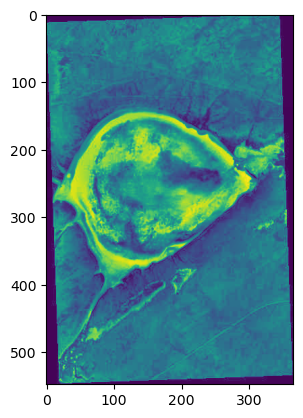

In [188]:
plt.imshow(preprocess(contrast_enhanced))  

Segment

Watershed

In [189]:
def watershed(image , org_image):

    ret, thresh = cv2.threshold(image,119,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    kernel = np.ones((3,3),np.uint8)
    
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
    
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
 
    markers = markers+1
    
    markers[unknown==255] = 0

    markers = cv2.watershed(org_image,markers)


    segments = np.zeros_like(org_image)

    segments[markers == -1] = [255,255 , 255]

    return segments , markers 

In [190]:
segment , marker = watershed(contrast_enhanced , image)

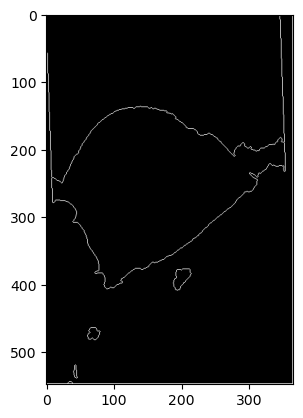

In [191]:
plt.imshow(segment)

In [192]:
cv2.imwrite(r'Outputs/watershed.jpg' , segment)

True

Grabcut

In [193]:
def grabcut(image):
    mask = np.zeros(image.shape[:2], np.uint8)

    rect = (10 , 10, 350, 500) 

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    segmented = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    result = image * segmented[:, :, np.newaxis]

    return result , segmented

In [194]:
result , segmented =  grabcut(image)

In [195]:
segmented.shape

(548, 366)

In [196]:
ret, segmented_th = cv2.threshold(segmented, 119, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

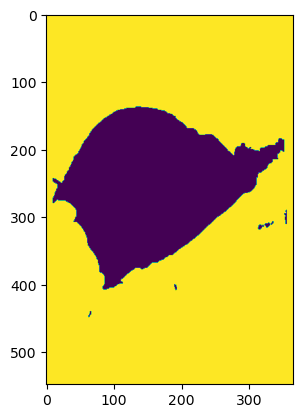

In [197]:
plt.imshow(segmented_th)

In [198]:
segmented_th.shape

(548, 366)

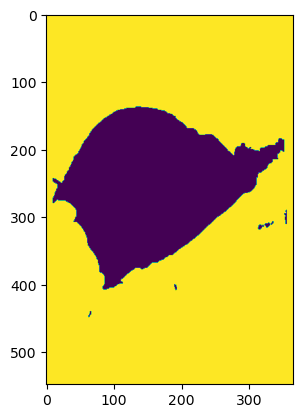

In [199]:
plt.imshow(np.expand_dims(segmented_th, axis=-1))

In [200]:
cv2.imwrite(r'Outputs/grabcut.jpg' , segmented_th)

True

Binary Thresholding

In [201]:
ret, binary_image = cv2.threshold(contrast_enhanced, 119, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

In [202]:
ret 

119.0

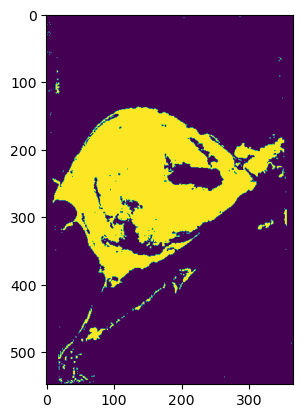

In [203]:
plt.imshow(binary_image)

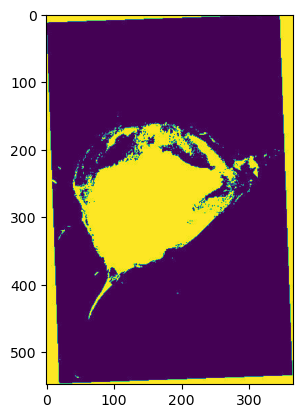

In [204]:
plt.imshow(mask)

In [205]:
binary_image.shape

(548, 366)

In [206]:
cv2.imwrite(r'Outputs/binary_mask.jpg' , binary_image )

True

Morphological Operations

In [207]:
image = cv2.imread('water_body.jpg')

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

lower_threshold = np.array([90, 0, 0])
upper_threshold = np.array([130, 255, 255])

mask = cv2.inRange(hsv, lower_threshold, upper_threshold)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
mask_ = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)


cv2.imwrite('Outputs/Morphology.jpg', mask_)


True

In [233]:
cv2.imwrite('Outputs/Morphology_inb.jpg', 255-mask_)


True

Graphcut

In [208]:
def graphcut_segmentation(image_path):

    image = cv2.imread(image_path)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

    x, y, w, h = 10 ,  10 , 350 , 500  
    mask = np.zeros(lab.shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, (x, y), (x+w, y+h), 1, -1)

    fgdModel = np.zeros((1, 65), dtype=np.float64)
    bgdModel = np.zeros((1, 65), dtype=np.float64)

    cv2.grabCut(lab, mask, (x, y, w, h), bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    return mask2

In [209]:
mask_gfcut = graphcut_segmentation(r'water_body.jpg')

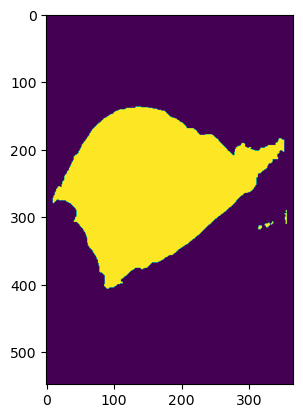

In [210]:
plt.imshow(graphcut_segmentation(r'water_body.jpg'))

In [211]:
cv2.imwrite(r'Outputs/graphcut.jpg' , mask_gfcut)

True

In [231]:
cv2.imwrite(r'Outputs/graphcut_inv.jpg' , 1-mask_gfcut)

True

Calculate Metrics

In [212]:
class MSELoss:
    def __init__(self):
        pass

    def forward(self, inputs, targets):
        inputs = inputs.flatten()
        targets = targets.flatten()

        mse_loss = np.mean((inputs - targets) ** 2)

        return mse_loss

In [213]:
class DiceLoss:
    def __init__(self, weight=None, size_average=True):
        pass

    def forward(self, inputs, targets, smooth=1e-1):
        inputs = np.where(inputs == 255, 1, 0).astype(np.uint8)
        targets = np.where(targets == 255, 1, 0).astype(np.uint8)

        inputs = inputs.flatten()
        targets = targets.flatten()

        intersection = np.sum(inputs * targets)
        dice = (2. * intersection + smooth) / (np.sum(inputs) + np.sum(targets) + smooth)

        return 1 - dice

In [214]:
ALPHA = 0.8
GAMMA = 2

class FocalLoss:
    def __init__(self, weight=None, size_average=True):
        pass

    def forward(self, inputs, targets, alpha=ALPHA, gamma=GAMMA, smooth=1e-1):

        inputs = np.where(inputs == 255, 1, 0).astype(np.uint8)
        targets = np.where(targets == 255, 1, 0).astype(np.uint8)

        inputs = 1 / (1 + np.exp(-inputs))

        inputs = inputs.flatten()
        targets = targets.flatten()

        BCE = -np.mean(targets * np.log(inputs + smooth) + (1 - targets) * np.log(1 - inputs + smooth))
        BCE_EXP = np.exp(-BCE)
        focal_loss = alpha * (1 - BCE_EXP) ** gamma * BCE

        return focal_loss

In [215]:
def calculate_metric(output , gt):

    mse = MSELoss()
    focal = FocalLoss()
    dice = DiceLoss()

    mse_score = np.mean((output - gt) ** 2)
    focal_score = focal.forward(output , gt)
    dice_score = dice.forward(output , gt)

    return mse_score , focal_score , dice_score

In [216]:
mask_gt = cv2.imread(r'water_body_Masked.jpg' , 0 )

Grabcut

In [217]:
mask_gbcut = cv2.imread(r'Outputs/grabcut.jpg' , 0)

In [228]:
mse , focal , dice = calculate_metric(mask_gbcut , mask_gt)

/tmp/ipykernel_23370/2493291116.py:13: RuntimeWarning: overflow encountered in exp
  inputs = 1 / (1 + np.exp(-inputs))


In [229]:
print("MSE Loss : " , mse)
print("Focal Loss : " , focal)
print("Dice : " , dice)

MSE Loss :  5.0536077539787
Focal Loss :  0.006575662968680263
Dice :  0.8614878650962436


Binary Thresholding

In [220]:
mask_bin = cv2.imread(r'Outputs/binary_mask.jpg' , 0)

In [221]:
mse , focal , dice =  calculate_metric(mask_bin.astype(np.uint8) , mask_gt.astype(np.uint8))

/tmp/ipykernel_23370/2493291116.py:13: RuntimeWarning: overflow encountered in exp
  inputs = 1 / (1 + np.exp(-inputs))


In [222]:
print("MSE Loss : " , mse)
print("Focal Loss : " , focal)
print("Dice : " , dice)

MSE Loss :  4.639778030393682
Focal Loss :  0.10954547971487046
Dice :  0.5048193713216962


Morphology

In [237]:
mask_morp = cv2.imread(r'Outputs/Morphology.jpg' , 0)

In [238]:
mse , focal , dice = calculate_metric( mask_morp.astype(np.uint8) , mask_gt.astype(np.uint8))

/tmp/ipykernel_23370/2493291116.py:13: RuntimeWarning: overflow encountered in exp
  inputs = 1 / (1 + np.exp(-inputs))


In [239]:
print("MSE Loss : " , mse)
print("Focal Loss : " , focal)
print("Dice : " , dice)

MSE Loss :  5.259722388416896
Focal Loss :  0.006950413715094329
Dice :  0.877344959077226


Graphcut

In [240]:
mse , focal , dice = calculate_metric(mask_gfcut.astype(np.uint8) , mask_gt.astype(np.uint8))

In [241]:
print("MSE Loss : " , mse)
print("Focal Loss : " , focal)
print("Dice : " , dice)

MSE Loss :  4.759408280483427
Focal Loss :  0.06534308250993491
Dice :  0.9999975278182254
